In [4]:
%pip install pandas numpy nltk scikit-learn keras tensorflow torch seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from collections import Counter
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#Functions for data preprocessing
def text_preprocessing(text):
    # Normalize text to lowercase
    text = text.lower()

    # Remove anything that is not a UTF-8 character
    text = text.encode("utf-8", "ignore").decode("utf-8")

    # Use regular expressions to remove all characters that are not letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Split text into words (tokens)
    words = text.split()

    # Load a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    return filtered_words
def pad_features(encoded_texts, sequence_length):
    features = np.zeros((len(encoded_texts), sequence_length), dtype=int)
    for i, row in enumerate(encoded_texts):
        features[i, -len(row):] = np.array(row)[:sequence_length]
    return features

def load_data(filename):
    df = pd.read_csv(filename)
    df['processed_text'] = df['Sentence'].apply(text_preprocessing)
    return df

def create_vocab_and_encode(df):
    all_words = [word for text in df['processed_text'] for word in text]
    counts = Counter(all_words)
    vocab = sorted(counts, key=counts.get, reverse=True)
    vocab_to_int = {word: i+1 for i, word in enumerate(vocab)}  # ensure indexing starts from 1
    df['encoded'] = df['processed_text'].apply(lambda x: [vocab_to_int[word] for word in x])
    vocab_size = len(vocab_to_int) 
    return df, vocab_to_int, vocab_size


In [7]:
#load dataset
df = load_data('output_from_amazon_imdb_yelp.csv')

df, vocab_to_int, vocab_size = create_vocab_and_encode(df)
sequence_length = 50
features = pad_features(list(df['encoded']), sequence_length)
labels = df['Sentiment'].values
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, output_dim=400))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {accuracy:.2%}, Test Loss: {loss:.4f}")
model.save('LSTM_FINAL.h5')

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5183 - loss: 0.6834 - val_accuracy: 0.7183 - val_loss: 0.5447
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8826 - loss: 0.3051 - val_accuracy: 0.7800 - val_loss: 0.5177
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9604 - loss: 0.1127 - val_accuracy: 0.7467 - val_loss: 0.7237
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9859 - loss: 0.0558 - val_accuracy: 0.7633 - val_loss: 0.7992
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9866 - loss: 0.0348 - val_accuracy: 0.7517 - val_loss: 0.9294
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9924 - loss: 0.0211 - val_accuracy: 0.7500 - val_loss: 0.9171
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9898 - loss: 0.0201 - val_accuracy: 0.7400 - val_loss: 1.1006
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9945 - loss: 0.0158 - val_accuracy: 0.7533 - 

Test Accuracy: 79.00%, Test Loss: 1.0770


In [8]:
# Happy Dataset
with open('hm_sample.txt', 'r', encoding='utf-8') as file:
    lines = file.read().split('\n')

df_happy = pd.DataFrame(lines, columns=['Sentence'])
df_happy['Sentiment'] = 1 
df_happy['processed_text'] = df_happy['Sentence'].apply(text_preprocessing)
df_happy['encoded'] = df_happy['processed_text'].apply(lambda x: [vocab_to_int.get(word, 0) for word in x])  # 0 for unknown words
df_happy = df_happy[df_happy['encoded'].apply(len) > 0]

sequence_length = 50 
features = pad_features(list(df_happy['encoded']), sequence_length)
happy_predictions = model.predict(features)
happy_labels_predicted = (happy_predictions > 0.5).astype(int).flatten()
happy_labels_true = df_happy['Sentiment'].values
conf_matrix_happy = confusion_matrix(happy_labels_true, happy_labels_predicted)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [9]:
#Sad Dataset
df_sad = pd.read_excel('SAD_v1.xlsx')
df_sad['processed_text'] = df_sad['sentence'].apply(text_preprocessing)
df_sad['Sentiment'] = 0
df_sad['encoded'] = df_sad['processed_text'].apply(lambda x: [vocab_to_int.get(word, 0) for word in x])
df_sad = df_sad[df_sad['encoded'].apply(len) > 0]
df_sad_padded = pad_features(list(df_sad['encoded']), sequence_length)
sad_predictions = model.predict(df_sad_padded)

sad_labels_true = df_sad['Sentiment'].values
# Convert predictions to binary labels
sad_labels_predicted = (sad_predictions > 0.5).astype(int).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


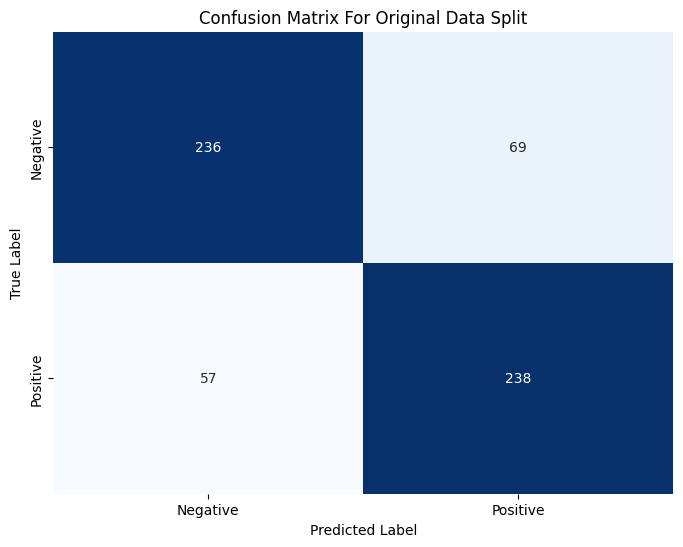

Classification Report For Original Data Split:
              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79       305
    Positive       0.78      0.81      0.79       295

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



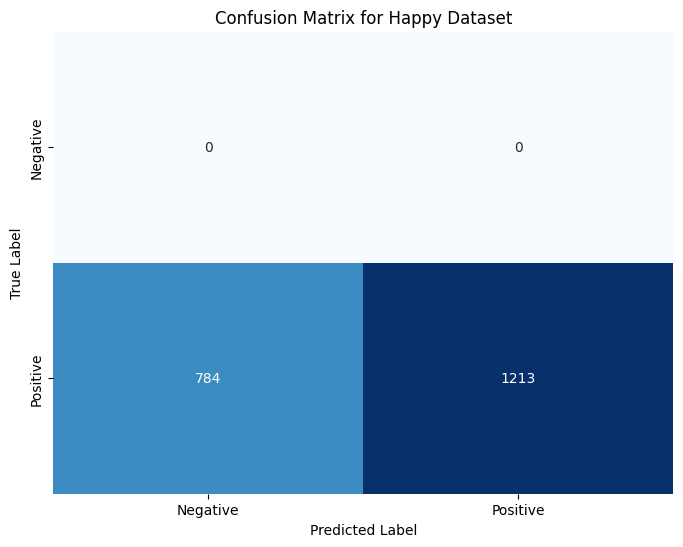

Classification Report for Happy Dataset:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
    Positive       1.00      0.61      0.76      1997

    accuracy                           0.61      1997
   macro avg       0.50      0.30      0.38      1997
weighted avg       1.00      0.61      0.76      1997



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


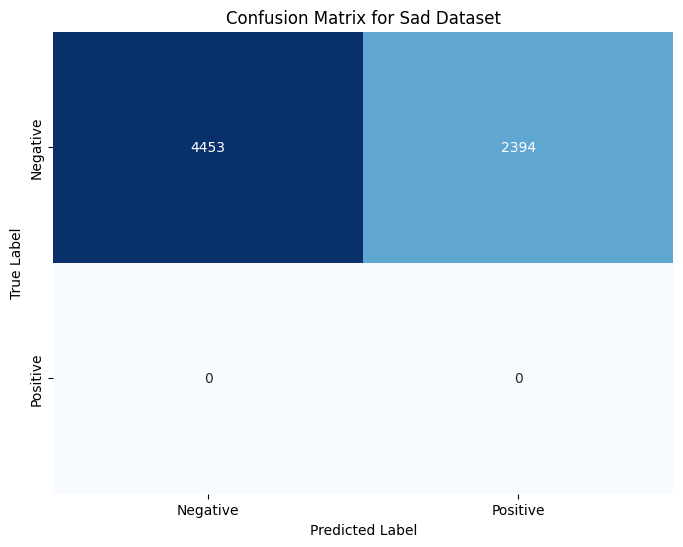

Classification Report for Sad Dataset:
              precision    recall  f1-score   support

    Negative       1.00      0.65      0.79      6847
    Positive       0.00      0.00      0.00         0

    accuracy                           0.65      6847
   macro avg       0.50      0.33      0.39      6847
weighted avg       1.00      0.65      0.79      6847



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:

# Plot Training Dataset
# Generate predictions
all_preds = model.predict(test_x)
all_preds = (all_preds > 0.5).astype(int)  # Convert probabilities to class labels

# Actual labels
all_labels = test_y
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix For Original Data Split')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
class_rep = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
print("Classification Report For Original Data Split:")
print(class_rep)

# Plot Happy Dataset Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_happy, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Happy Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Generate classification report
class_report_happy = classification_report(happy_labels_true, happy_labels_predicted, target_names=['Negative', 'Positive'])

# Print classification report
print("Classification Report for Happy Dataset:")
print(class_report_happy)

# Plot Sad Dataset Confusion Matrix
# Compute the confusion matrix
conf_matrix_sad = confusion_matrix(sad_labels_true, sad_labels_predicted)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sad, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Sad Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate the classification report
class_report_sad = classification_report(sad_labels_true, sad_labels_predicted, target_names=['Negative', 'Positive'])

# Print the classification report
print("Classification Report for Sad Dataset:")
print(class_report_sad)

In [11]:
def analyze_user_input(text, model, vocab_to_int, sequence_length):
    # Preprocess the text
    processed_text = text_preprocessing(text)
    
    # Encode the preprocessed text with the existing vocab_to_int mapping
    encoded_text = [vocab_to_int.get(word, 0) for word in processed_text]
    
    # Pad the encoded text
    padded_text = pad_features([encoded_text], sequence_length)
    
    # Predict the sentiment
    prediction = model.predict(np.array(padded_text))
    predicted_sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
    
    # Output result
    return predicted_sentiment


# Assuming the variables `model`, `vocab_to_int`, and `sequence_length` are already defined
# Sample usage
user_input = "i am very sad today."
sentiment_result = analyze_user_input(user_input, model, vocab_to_int, sequence_length)
if sentiment_result == 'Negative':
    print(f"Prompt to chatbot: The user seems to be feeling down based on their last message '{user_input}'. Provide some supportive responses or ask if they'd like to talk about what's bothering them?")
else:
    print(f"Prompt to chatbot: The user appears to be feeling good based on their last message '{user_input}'. Keep the conversation light and positive.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prompt to chatbot: The user seems to be feeling down based on their last message 'i am very sad today.'. Provide some supportive responses or ask if they'd like to talk about what's bothering them?
